# Descarga imagen

En primer lugar vamos a descargar la imagen con la que vamos a trabajar en la primera parte de la sesión.


In [ ]:
# Importamos librerías para interactuar con Google Drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Nos autenticamos con nuestra cuenta de Google Drive para acceder a los datos
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Nos descargamos las imagenes que vamos a emplear
download = drive.CreateFile({'id': '1sUgi4yM7If5YuynuswaN1UIajmpQq0-w'})
download.GetContentFile('imagen2.jpeg')

# Parte I: Filtro convolucional

Vamos a visualizar los filtros ajustados por una CNN ya existente, así como el mapa de características (imagen filtrada) generada por dichos filtros.

Para ello, vamos a emplear una arquitectura que se diseñó hace unos años (VGG16 - 2014) y que fue entrenada sobre la base de datos de ImageNet.

Por lo tanto, lo primero que vamos a hacer es importar dicha arquitectura que se encuentra dentro de la propia API de Tensorflow.

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [ ]:
model = VGG16(include_top=False, weights='imagenet')

model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [ ]:
# Mostramos las capas convolucionales que contiene VGG16

for l, layer in enumerate(model.layers):
    if 'conv' not in layer.name:
        continue
    filters, biases = layer.get_weights()
    print('Capa', l, ':', layer.name, filters.shape)

Capa 1 : block1_conv1 (3, 3, 3, 64)
Capa 2 : block1_conv2 (3, 3, 64, 64)
Capa 4 : block2_conv1 (3, 3, 64, 128)
Capa 5 : block2_conv2 (3, 3, 128, 128)
Capa 7 : block3_conv1 (3, 3, 128, 256)
Capa 8 : block3_conv2 (3, 3, 256, 256)
Capa 9 : block3_conv3 (3, 3, 256, 256)
Capa 11 : block4_conv1 (3, 3, 256, 512)
Capa 12 : block4_conv2 (3, 3, 512, 512)
Capa 13 : block4_conv3 (3, 3, 512, 512)
Capa 15 : block5_conv1 (3, 3, 512, 512)
Capa 16 : block5_conv2 (3, 3, 512, 512)
Capa 17 : block5_conv3 (3, 3, 512, 512)


In [ ]:
# Cogemos los pesos aprendidos (filtros y sesgo) de la primera capa
filters, biases = model.layers[1].get_weights()

print('Número filtros: ', filters.shape[3])
print('Número canales: ', filters.shape[2])
print('Tamaño de cada filtro: ', filters.shape[:2])

Número filtros:  64
Número canales:  3
Tamaño de cada filtro:  (3, 3)


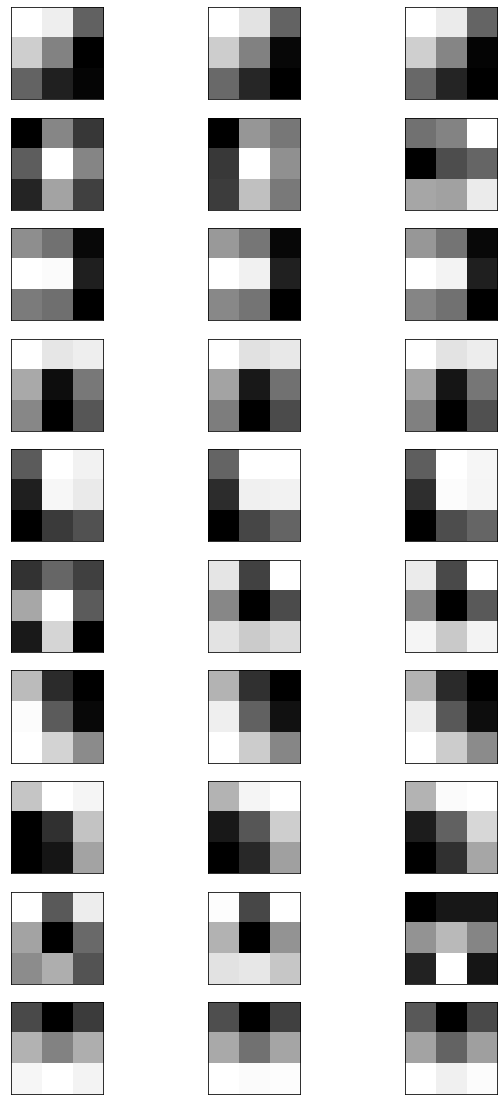

In [ ]:
# Normalizamos los valores de los filtros para que estén contenidos entre 0 y 1 y se puedan visualizar adecuadamente
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# Vamos a visualizar 10 filtros
n_filters, ix = 10, 1

plt.figure(figsize=(10,20))

for i in range(n_filters):

    f = filters[:, :, :, i]

    # Para cada filtro visualizamos 3 canales
    for j in range(3):
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])

        plt.imshow(f[:, :, j], cmap='gray')
        ix += 1

plt.show()

En la figura anterior podemos ver los filtros obtenidos en la primera capa convolucional de la arquitectura que hemos cargado (VGG16). En esta capa tenemos, para cada canal de la capa anterior (3 canales en nuestro caso), 64 filtros de 3x3.
En filas hemos representado 20 de los 64 filtros y en cada columna tenemos el filtro para cada uno de los 3 canales.
Podemos ver que hay algunos casos en los que los filtros son iguales para los tres canales (e.g. primera fila), mientras que en otros casos, los filtros son diferentes.

Los cuadrados más negros indican un valor de peso bajo, mientras que cuadrados más claros indican un valor de peso alto. Por lo tanto, podríamos decir que en la primera fila tenemos filtros que detectan gradientes de intensidad de claro en la esquina superior izquierda a oscuro en la esquina inferior derecha. O, por ejemplo, en la quinta y septima fila vemos filtros que destacan esquinas.



A continuación, vamos a ver las imágenes que salen de un filtro convolucional (mapa de características).

(-0.5, 1499.5, 999.5, -0.5)

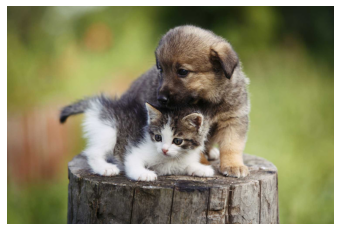

In [ ]:
# Cargamos imagen y la preprocesamos
image = Image.open('imagen2.jpeg')
image = np.array(image)
plt.imshow(image)
plt.axis('off')

In [ ]:
# Preparamos la imagen para introducirla en el modelo para que tenga el formato [n casos, n filas, n columnas, n canales]
image = np.expand_dims(image, axis=0)

# Función para preprocesar la imagen de igual forma que se hizo para el desarrollo de VGG16
image = preprocess_input(image)

print('Tamaño imagen: ', image.shape)

Tamaño imagen:  (1, 1000, 1500, 3)


In [ ]:
# Seleccionamos capa de la que queremos generar el mapa de características
layer = model.layers[2]
# Creamos modelo auxiliar en el que a la salida tengamos la salida de la capa deseada
model_aux = Model(inputs=[model.input], outputs=[layer.output])

# Generamos mapa de características
feature_maps = model_aux.predict(image)

In [ ]:
feature_maps.shape

(1, 1000, 1500, 64)

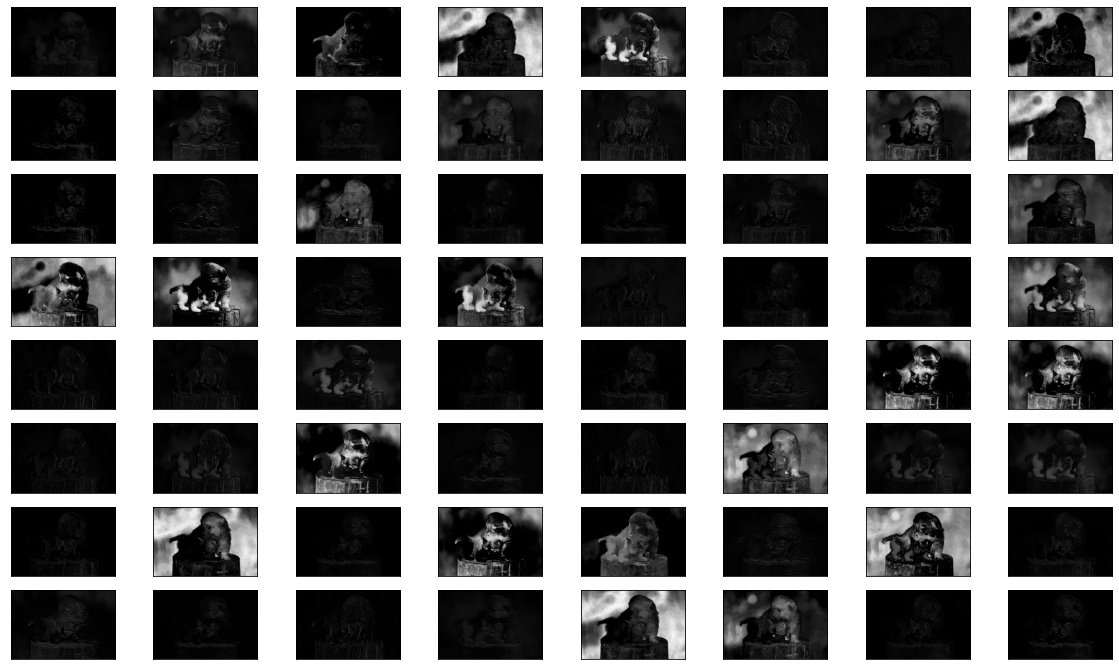

In [ ]:
square = 8
ix = 1
plt.figure(figsize=(20,12))
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
plt.show()

# Parte II: Bloques redes neuronales convolucionales

En esta segunda parte de la sesión vamos a ver cómo implementar algunos de los bloques principales que podemos encontrar en una CNN haciendo uso de la API de Tensorflow/Keras.

Vamos a cargar una imagen que será la que emplearemos para ver la salida de cada uno de los bloques que implementemos.

In [ ]:
from tensorflow.keras import layers

In [ ]:
img = Image.open('imagen2.jpeg')
img = np.array(img)

# Añadimos primera dimensión para construir matriz tal que tengamos [n imagenes, n filas, n columnas, n canales]
img = np.expand_dims(img, axis=0)

print('Tamaño de imagen original: ', img.shape)

Tamaño de imagen original:  (1, 1000, 1500, 3)


## Filtro convolucional

In [ ]:
# Capa de entrada donde especificamos el tamaño de la imagen de entrada (n filas, n columnas, n canales)
input_layer = layers.Input(shape=img.shape[1:])

# Capa convolucional con 8 filtros de tamaño 3x3
layer_conv = layers.Conv2D(filters=8, kernel_size=(3, 3))(input_layer)

model = Model(inputs=[input_layer], outputs=[layer_conv])

model.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 1000, 1500, 3)]   0         
                                                                 
 conv2d_56 (Conv2D)          (None, 998, 1498, 8)      224       
                                                                 
Total params: 224
Trainable params: 224
Non-trainable params: 0
_________________________________________________________________


En la anterior capa convolucional no hemos especificado ni el stride ni el padding. Si miramos la [documentación de Keras](https://keras.io/api/layers/convolution_layers/convolution2d/), si no se especifica nada, por defecto se toma un valor de strides=(1,1) y padding="valid". Si queremos cambiar su valor deberemos de especificarlo.

In [ ]:
# Vemos el efecto del stride

input_layer = layers.Input(shape=img.shape[1:])

layer_conv = layers.Conv2D(filters=8, kernel_size=(3, 3), strides=(2,2))(input_layer)

model = Model(inputs=[input_layer], outputs=[layer_conv])

model.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 1000, 1500, 3)]   0         
                                                                 
 conv2d_48 (Conv2D)          (None, 499, 749, 8)       224       
                                                                 
Total params: 224
Trainable params: 224
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Vemos el efecto del padding

input_layer = layers.Input(shape=img.shape[1:])

layer_conv = layers.Conv2D(filters=8, kernel_size=(3, 3), strides=(2,2), padding="same")(input_layer)

model = Model(inputs=[input_layer], outputs=[layer_conv])

model.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 1000, 1500, 3)]   0         
                                                                 
 conv2d_49 (Conv2D)          (None, 500, 750, 8)       224       
                                                                 
Total params: 224
Trainable params: 224
Non-trainable params: 0
_________________________________________________________________


**¿Por qué se ha reducido la imagen a la mitad si hemos puesto padding="same"?**

Vemos el tamaño de la imagen de salida que genera la última capa que hemos creado y si se corresponde con lo que dice el "summary".

In [ ]:
img_model = model.predict(img)

print('Tamaño imagen filtrada: ', layer_conv.shape)

Tamaño imagen filtrada:  (None, 500, 750, 8)


**¿Por qué la imagen de salida tiene 8 canales?**

## Ejercicio 1

Implementa una capa convolucional con las siguientes propiedades:

* Tamaño de filtro: 5x5
* Número de filtros: 16
* Stride: 1x1
* Padding: Aquel que genere una imagen de salida de igual tamaño que la imagen de entrada.

Preguntas:
* Calcula el número de parámetros que va a tener que ajustar la capa que hemos implementado, ¿coincide con lo especificado por Keras?
* ¿Cuál es el tamaño de la imagen de salida?
* ¿Qué padding es el apropiada para conseguir nuestros objetivos?

In [ ]:
# TO DO
...

## Función de activación

Tras cada filtro convolucional hay que aplicar una función de activación.
Esta se puede implementar de dos formas diferentes:

* Como argumento dentro de la capa convolucional.
* Como un capa nueva tras la capa convolucional.

In [ ]:
# Como argumento dentro de la capa convolucional
input_layer = layers.Input(shape=img.shape[1:])
layer_conv = layers.Conv2D(filters=8, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="relu")(input_layer)

model = Model(inputs=[input_layer], outputs=[layer_conv])

model.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 1000, 1500, 3)]   0         
                                                                 
 conv2d_50 (Conv2D)          (None, 500, 750, 8)       224       
                                                                 
Total params: 224
Trainable params: 224
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Como una capa nueva tras la capa convolucional
input_layer = layers.Input(shape=img.shape[1:])
layer_conv = layers.Conv2D(filters=8, kernel_size=(3, 3), strides=(2, 2), padding="same")(input_layer)
act = layers.Activation("relu")(layer_conv)

model = Model(inputs=[input_layer], outputs=[act])

model.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 1000, 1500, 3)]   0         
                                                                 
 conv2d_51 (Conv2D)          (None, 500, 750, 8)       224       
                                                                 
 activation (Activation)     (None, 500, 750, 8)       0         
                                                                 
Total params: 224
Trainable params: 224
Non-trainable params: 0
_________________________________________________________________


Esta segunda opción es de especial interés cuando queremos emplear una función de activación parametrizable (e.g., LeakyRelu).

**NOTA:** Cuando la función de activación se intrudza como argumento dentro de la capa convolucional no la veremos reflejada en el "summary", en cambio, cuando la incorporemos como capa adicional si aparecerá. Ambas aproximaciones dan el mismo resultado.

**NOTA:** No vamos a experimentar más con las funciones de activación ya que lo veréis en la parte de datos estructurados, donde se emplean las mismas funciones de activación que en CNNs.

Únicamente nos vamos a quedar con que para filtros convolucionales en la gran mayoría de los casos vamos a emplear función de activación ReLU (para casos particulares lo iremos viendo conforme nos los vayamos encontrando).

## Pooling o agrupación

En Keras emplearemos la clase MaxPool2D o MaxPooling2D (ambas hacen lo mismo).

In [ ]:
input_layer = layers.Input(shape=img.shape[1:])
layer_conv = layers.Conv2D(filters=8, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="relu")(input_layer)
# Capa de Max pooling para dividir la imagen a la mitad
pool = layers.MaxPool2D(pool_size=(2, 2))(layer_conv)

model = Model(inputs=[input_layer], outputs=[pool])

model.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 1000, 1500, 3)]   0         
                                                                 
 conv2d_53 (Conv2D)          (None, 500, 750, 8)       224       
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 250, 375, 8)      0         
 g2D)                                                            
                                                                 
Total params: 224
Trainable params: 224
Non-trainable params: 0
_________________________________________________________________


## Ejercicio 2

Implementa un modelo que tenga las siguientes características:

* Capa de entrada de tamaño 256x256x3
* Dos capas convolucionales (una a continuación de la otra) con las siguientes propiedades:
      * 1ª capa: 16 filtros de 3x3, con stride (1,1) y padding tal que mantenga el tamaño de la imagen de entrada.
      * 2ª capa: 32 filtros de 5x5, con stride (2,2) y sin padding.

* Las dos capas convolucionales emplearán una función de activación ReLU.
* Capa de Max Pooling de forma que se reduzca el tamaño de la imagen a la mitad.

**PREGUNTAS:**
* ¿Qué tamaño de imagen de salida habéis obtenido?
* ¿Cuántos parámetros debe ajustar el modelo en total?









In [ ]:
# TO DO
...

## Clasificación

Ahora vamos a ver como tenemos que diseñar la CNN para resolver una problema de clasificación y que bloques vamos a emplear.

### Flatten / Global Average Pooling

Ambas capas se emplean para convertir la salida de la última capa de extracción de características donde tenemos imágenes (matrices) en un vector.

In [ ]:
input_layer = layers.Input(shape=img.shape[1:])
layer_conv = layers.Conv2D(filters=8, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="relu")(input_layer)
pool = layers.MaxPool2D(pool_size=(2, 2))(layer_conv)

# Capa de flatten
flatten = layers.Flatten()(pool)

model = Model(inputs=[input_layer], outputs=[flatten])

model.summary()

Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 1000, 1500, 3)]   0         
                                                                 
 conv2d_62 (Conv2D)          (None, 500, 750, 8)       224       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 250, 375, 8)      0         
 g2D)                                                            
                                                                 
 flatten_12 (Flatten)        (None, 750000)            0         
                                                                 
Total params: 224
Trainable params: 224
Non-trainable params: 0
_________________________________________________________________


La capa Flatten convierte la salida de la capa anterior en un vector sin aplicarles ningún tipo de transformación. Por ese motivo, la capa flatten genera como salida un vector de tamaño 750000 (250*375*8).

In [ ]:
input_layer = layers.Input(shape=img.shape[1:])
layer_conv = layers.Conv2D(filters=8, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="relu")(input_layer)
pool = layers.MaxPool2D(pool_size=(2, 2))(layer_conv)

# Capa de GlobalAveragePooling
global_avg = layers.GlobalAveragePooling2D()(pool)

model = Model(inputs=[input_layer], outputs=[global_avg])

model.summary()

Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 1000, 1500, 3)]   0         
                                                                 
 conv2d_63 (Conv2D)          (None, 500, 750, 8)       224       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 250, 375, 8)      0         
 g2D)                                                            
                                                                 
 global_average_pooling2d (G  (None, 8)                0         
 lobalAveragePooling2D)                                          
                                                                 
Total params: 224
Trainable params: 224
Non-trainable params: 0
_________________________________________________________________


La capa Global Average Pooling genera un vector de tantas componentes como canales tiene la imagen de salida de la capa anterior y, por cada canal, preserva el valor medio.
Por ello, como la capa anterior (max_pooling_2d) tiene 8 canales, la salida de la capa de global_average_pooling tiene es un vector de 8 componentes.

### Capa totalmente conectada (Dense)

Finalmente vamos a implementar una serie de capas ocultas y la capa de salida para resolver un problema de calsificación.

In [ ]:
input_layer = layers.Input(shape=img.shape[1:])
layer_conv = layers.Conv2D(filters=8, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="relu")(input_layer)
pool = layers.MaxPool2D(pool_size=(2, 2))(layer_conv)

global_avg = layers.GlobalAveragePooling2D()(pool)

# Capa oculta
dense_hidden = layers.Dense(32, activation='relu')(global_avg)
# Capa de salida: suponemos problema de clasificación multiclase con 4 salidas
dense_output = layers.Dense(4, activation='softmax')(dense_hidden)

model = Model(inputs=[input_layer], outputs=[dense_output])

model.summary()

Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 1000, 1500, 3)]   0         
                                                                 
 conv2d_66 (Conv2D)          (None, 500, 750, 8)       224       
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 250, 375, 8)      0         
 g2D)                                                            
                                                                 
 global_average_pooling2d_3   (None, 8)                0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_26 (Dense)            (None, 32)                288       
                                                                 
 dense_27 (Dense)            (None, 4)                 132

## Ejercicio 3

Implementa la misma arquitectura que en el Ejercicio 2 y añade las siguientes capas:

* Capa Flatten.
* 2 capas ocultas densas con 16 y 32 neuronas respectivamente, ambas con función de activación ReLu.
* 1 capa de salida con 1 neurona y función de activación sigmoide ("sigmoid").

**PREGUNTAS:**
* ¿Cuántos parámetros debe ajustar el modelo en total?

In [ ]:
# TO DO
...

## Ejercicio 4

Implementa la misma arquitectura que en el Ejercicio 3 pero emplea una capa GlobalAveragePooling2D en lugar de Flatten.

**PREGUNTAS:**
* ¿Cuántos parámetros debe ajustar el modelo en total?

In [ ]:
# TO DO
...

# Parte III: Red Neuronal Convolucional (CNN)

En esta parte de la sesión vamos a cargar una base de datos, implementar una arquitectura y entrenarla para resolver un problema de clasificación.

Para ello, vamos a hacer uso de una base de datos formada por perros y gatos y vemos a tratar de entrenar un modelo de clasificación que sea capaz de diferenciar ambas clases.

El principal objetivo de esta parte es entender correctamente como cargar una base de datos y prepararla, como implementar una arquitectura y como realizar el ajuste de la misma, por lo tanto, no nos centraremos tanto en conseguir buenos resultados.

In [ ]:
import tensorflow as tf
from PIL import Image
import numpy as np
from pathlib import Path
import glob
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

root_path = Path('drive/My Drive/mislata_ia_imagenes/')

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin=_URL, extract=True)

In [ ]:
print(path_to_zip)

In [ ]:
# Convertimos directorio a directorio de pathlib
path_to_zip = Path(path_to_zip)
path_datasets = path_to_zip.parent
print(list(path_datasets.iterdir()))
path_dataset = path_datasets / 'cats_and_dogs_filtered'
print('Contenido carpeta descargada: ', list(path_dataset.iterdir()))

In [ ]:
path_train = path_dataset / 'train'
path_val = path_dataset / 'validation'

print('Contenido carpeta entrenamiento: ')
print(list(path_train.iterdir()))
print('Contenido carpeta validación: ')
print(list(path_val.iterdir()))

In [ ]:
path_dogs_train = path_train / 'dogs'
list(path_dogs_train.iterdir())



# **Cargado de las imágnes en lotes**

Para esto vamos a hacer uso del método de Tensorflow/Keras image_dataset_from_directory. Este método facilita la creación de datasets legibles por Tensorflow. Solo necesitamos tener las imágenes en nuestro sistema de archivos ordenadas de manera apropiada. Esto es, las imágenes pertenecientes a cada clase en una carpeta diferente. No es necesario tener carpeta de entrenamiento y validación, podemos crear posteriormente las particiones si todas las imágenes se encuentran en una única carpeta.

En este método las etiquetas son inferidas, es decir, genera lotes de imágenes de los subdirectorios dentro de la carpeta, asignándoles etiquetas diferentes (cats -> 0, dogs -> 1). Si no se especifica de otra forma, la asignación de etiquetas se realiza en orden alfabético.

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

n_rows = 160
n_cols = 160

# A diferencia del método anterior, aquí ya tenemos que especificar el tamaño del lote que se va a emplear durante el entrenamiento
BATCH_SIZE = 32

# El argumento "shuffle" a True hace que las imágenes se carguen y se reordenen de forma aleatoria
# Por lo que este paso ya no hará falta que lo hagamos manualmente como antes
train_dataset = image_dataset_from_directory(
    path_train,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=(n_rows, n_cols)
    )

validation_dataset = image_dataset_from_directory(
    path_val,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=(n_rows, n_cols)
    )

Podemos ver que el método ha encontrado el número de imágenes y etiquetas esperado tanto para el conjunto de datos de entrenamiento como el de validación

In [ ]:
class_names = train_dataset.class_names
print('Etiquetas encontradas: ', class_names)

In [ ]:
plt.figure(figsize=(10, 10))
# En un dataset creado de la forma anterior podemos emplear el método "take" para coger n número de lotes. En nuestro caso vamos a coger 1
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    if labels[i] == 0:
        plt.title('Gato')
    elif labels[i] == 1:
        plt.title('Perro')
    plt.axis("off")

En este punto ya hemos cargado las imágenes, las hemos redimensionado y las hemos reordenados para que tengan un orden aleatorio (en muchas menos líneas de código!!), nos queda generar las particiones de entrenamiento, validación y test y realizar el escalado.

En primer lugar vamos a generar las 3 particiones dividiendo, como hicimos en el otro caso, el conjunto de validación en dos particiones (validación y test)

In [ ]:
# Obtenemos cuantos lotes tiene la partición original de validación
val_batches = tf.data.experimental.cardinality(validation_dataset)
print('Número de lotes de validación original: ', val_batches.numpy())

# Asignamos la mitad a cada partición
test_dataset = validation_dataset.take(val_batches // 2) # Cogemos la mitad
validation_dataset = validation_dataset.skip(val_batches // 2) # Eliminamos la mitad
print('Número de lotes de validación: ', tf.data.experimental.cardinality(validation_dataset).numpy())
print('Número de lotes de test: ', tf.data.experimental.cardinality(test_dataset).numpy())

In [ ]:
# Obtenemos numero de lotes que forman la partición de entrenamiento
train_batches = tf.data.experimental.cardinality(train_dataset)
print('Número de lotes de entrenamiento: ', train_batches.numpy())

El siguiente bloque de código se añade por defecto cuando queramos leer imágenes del sistema de archivos de manera dinámica para evitar que la E/S se bloquee. Permite mejorar el rendimiento en la carga de datos.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Finalmente, realizamos el escalado de las imágenes. En este punto, nos encontramos con un inconveniente, y es que las aproximaciones featurewise no las podemos aplicar en este caso (a no ser que calculemos la media y desviación estándar de manera independiente), ya que en memoria únicamente vamos a tener cargado 1 lote simultáneamente.

El resto de escalados si que podremos aplicarlos, vamos a ver como.

In [ ]:
# Vamos a ver valores de intensidad mínimo y máximo de una imagen antes de realizar el escalado
for images, labels in train_dataset.take(1):
  print('Intensidad mínima: ', images[0].numpy().min())
  print('Intensidad máxima: ', images[0].numpy().max())

In [ ]:
# Vamos a hacer uso de la función "map" que aplica a cada registro dentro del dataset la transformación que nosotros definamos, en nuestro caso "scaling"
# A la función que llamemos con "map" siempre le van a entrar los mismos dos argumentos: "image" y "label".

def scaling_normalization(image, label):
    image = tf.cast(image/255., tf.float32)
    return image, label

train_dataset = train_dataset.map(scaling_normalization)
validation_dataset = validation_dataset.map(scaling_normalization)
test_dataset = test_dataset.map(scaling_normalization)

In [ ]:
# Vemos nuevos valores de intensidad mínimo y máximo tras realizar el escalado
for images, labels in train_dataset.take(1):
  print('Intensidad mínima: ', images[0].numpy().min())
  print('Intensidad máxima: ', images[0].numpy().max())

# **Definición de la arquitectura**

Una vez tenemos los datos listos podemos proceder a definir la arquitectura a entrenar. En primer lugar tenemos que definir el conjunto de capas que forman nuestra arquitectura.

## Ejercicio 5

Implementa una arquitectura que se ajuste al siguiente "summary" donde el tamaño de los filtros convolucionales es de 3x3 y se emplea una función de activación de tipo ReLU en dichos filtros.
En la capa densa oculta también se emplea una función de activación ReLU.
Finalmente, en la capa densa de salida, se hace uso de la función de activación sigmoide ("sigmoid").

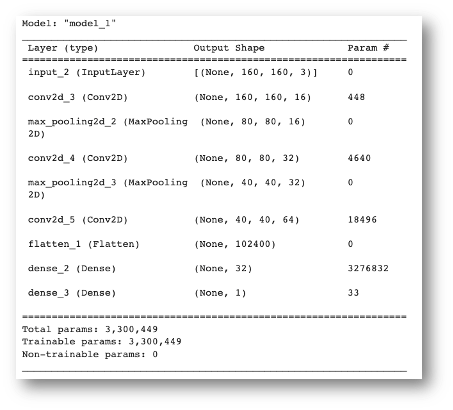

In [ ]:
# TODO

def create_model():

  # TODO

  model_base = ...

  return model_base

In [ ]:
model_base = create_model()
model_base.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 160, 160, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 80, 80, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 80, 80, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 40, 40, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 64)        1849

# Compilación y entrenamiento

Ya tenemos la arquitectura definida, para poder inicializar el entrenamiento solo nos queda definir la tasa de aprendizaje, la función de coste y las métricas.
La tasa de aprendizaje la definiremos a través de argumento "optimizer", la función de coste a través del argumento "loss" y las métricas irán definidas dentro de una lista y se definirán a través del argumento "metrics".

- Como tasa de aprendizaje vamos a emplear el optimizador Adam con sus parámetros definidos por defecto, esto lo podremos definir a través de la palabra clave "adam" ya que es algo que Keras entiende internamente.
- Como función de pérdidas, al tratarse de un problema de clasificación binaria emplearemos la entropía cruzada binaria. Para esto Keras también tiene la palabra clave: "binary_crossentropy".
- Como métricas, al tratarse de un problema de clasificación, la métrica que más nos interesa es la exactitud (accuracy en inglés). Para esto también haremos uso de la palabra clave "accuracy".

In [ ]:
model_base.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Finalmente, ya podemos pasar a realizar el entrenamiento del modelo, para ello vamos a hacer uso del método "fit".

Durante el entrenamiento vamos a emplear un "callback" de Keras que nos va a ser de gran utilidad y que emplearemos **SIEMPRE** cuando entrenemos un modelo.

Se trata del callback [ModelCheckpoint](https://keras.io/api/callbacks/model_checkpoint/). Este permite almacenar el modelo en ciertos puntos del entrenamiento. Nosotros lo vamos a emplear para almacenar el modelo en el que tengamos las mejores métricas de validación.

Vamos a crearnos una carpeta para el experimento que estamos realizando donde se almacenará dicho modelo. Para organizar todos los experimentos que habamos vamos a crearnos la carpeta "models" y dentro de esta, crearemos la carpeta "Train1" donde guardaremos los resultados del experimento actual.

In [ ]:
path_project = root_path / 'dogs_cats'
path_models = path_project / 'models'
path_experiment = path_models / 'Train1'

path_experiment.mkdir(exist_ok=True, parents=True)

In [ ]:
# Inicializamos el callback
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=path_experiment / 'dogs_and_cats.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

# Entrenamos
history_model_base = model_base.fit(train_dataset,
                                    epochs=10,
                                    validation_data=validation_dataset,
                                    callbacks=[model_checkpoint_callback],
                                    verbose=1)

En la carpeta que hemos creado también vamos a almacenar la historia. Esto nos será de ayuda si en cualquier momento queremos revisar los resultados de un experimento dado.

In [ ]:
np.save(path_experiment / 'history.npy', history_model_base.history)

Visualizamos los resultados

In [ ]:
# Método para la visualización de la exactitud obtenida durante el proceso de entrenamiento tanto en entrenamiento como en validación
def plot_losses(history):
    plt.plot(history.history['loss'], label="Entrenamiento")
    plt.plot(history.history['val_loss'], label="Validación")
    plt.ylabel('Pérdidas')
    plt.xlabel('Época')
    plt.legend(loc="upper right")
    plt.title('Pérdidas durante el entrenamiento')

# Método para la visualización de la exactitud obtenida durante el proceso de entrenamiento tanto en entrenamiento como en validación
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label="Entrenamiento")
    plt.plot(history.history['val_accuracy'], label="Validación")
    plt.ylabel('Exactitud')
    plt.xlabel('Época')
    plt.legend(loc="upper right")
    plt.title('Exactitud durante el entrenamiento')

In [ ]:
plot_losses(history_model_base)

In [ ]:
plot_accuracy(history_model_base)

**¿Qué podemos interpretar de las gráficas anteriores?**

Finalmente, evaluamos el modelo entrenado sobre la base de datos de test. Si empleamos el modelo que tenemos ahora mismo cargado en memoria (model_base), estaremos evaluando el modelo correspondiente a la última época. Por lo tanto, para evaluar aquel que mejor resultado en validación nos ha dado vamos a cargarlo previamente.

In [ ]:
# Cargamos el modelo
model_base = tf.keras.models.load_model(path_experiment / 'dogs_and_cats.h5')

In [ ]:
# Extraemos métricas test
_, acc_base = model_base.evaluate(test_dataset, verbose=0)
print('Exactitud test: ', acc_base)

# Experimentación

## Ejercicio 6

Implementa una arquitectura que responda al siguiente summary.
* Filtros convolucionales de 3x3 con función de activación ReLU.
* Capa densa oculta con función de activacuón ReLU.
* Capa densa de salida con función de activación Sigmoide.

**PISTA**: Con respecto a la arquitectura que hemos empleado antes solo hay un pequeño cambio en los filtros convolucionales.

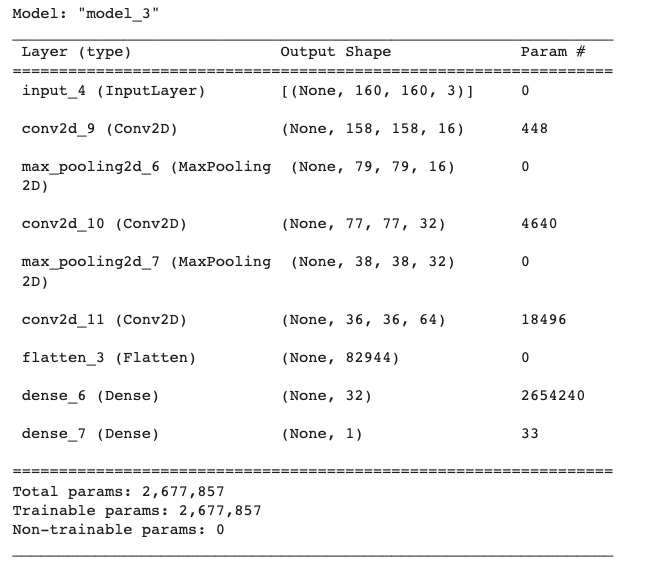

In [ ]:
# TO DO
...

## Ejercicio 7

Implementa una arquitectura que responda al siguiente summary.
* Filtros convolucionales de 3x3 con función de activación ReLU.
* Capa densa oculta con función de activacuón ReLU.
* Capa densa de salida con función de activación Sigmoide.

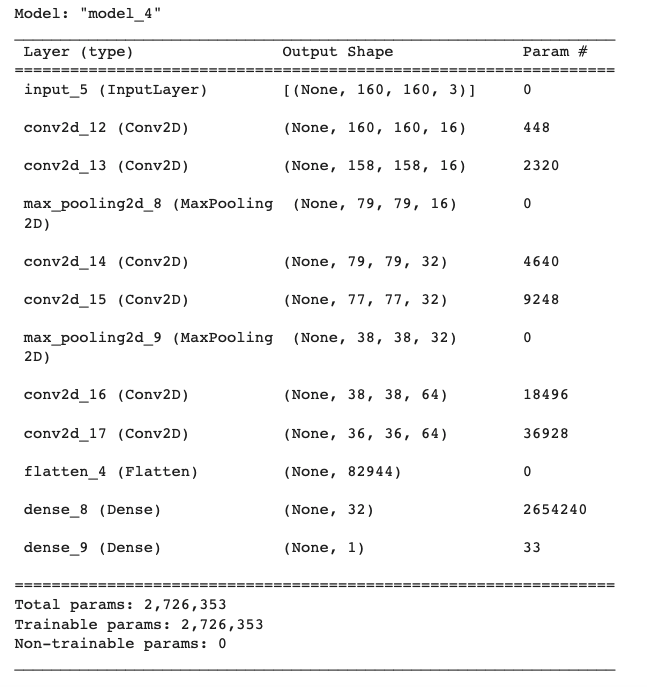

In [ ]:
# TO DO
...

## Ejercicio 8

Implementa una arquitectura que responda al siguiente summary.
* Filtros convolucionales de 3x3 con función de activación ReLU.
* Capa densa oculta con función de activacuón ReLU.
* Capa densa de salida con función de activación Sigmoide.

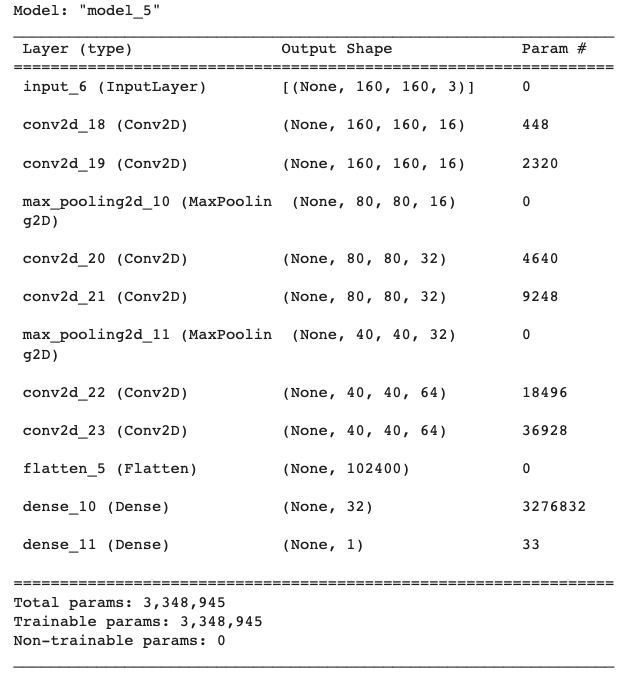

In [ ]:
# TO DO
...

## Ejercicio 9

Implementa una arquitectura que responda al siguiente summary.
* Filtros convolucionales de 3x3 con función de activación ReLU.
* Capa densa oculta con función de activacuón ReLU.
* Capa densa de salida con función de activación Sigmoide.

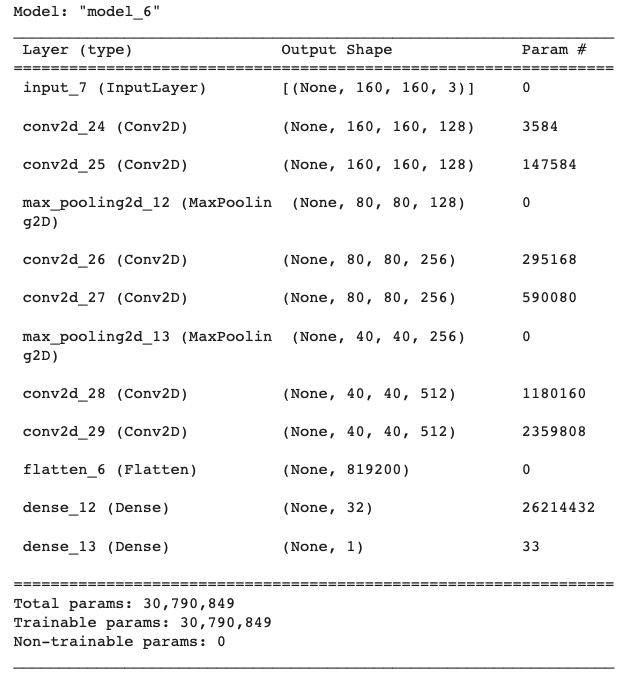

In [ ]:
# TO DO
...

## Ejercicio 10

Implementa una arquitectura que responda al siguiente summary.
* Filtros convolucionales de 3x3 con función de activación ReLU.
* Capas densas ocultas con función de activacuón ReLU.
* Capa densa de salida con función de activación Sigmoide.

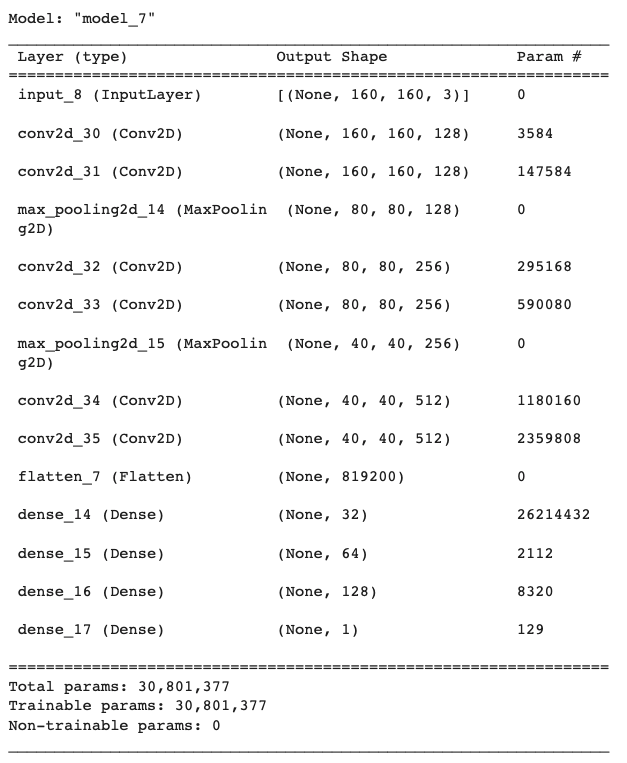

In [ ]:
# TO DO
...

## Ejercicio 11

Implementa una arquitectura que responda al siguiente summary.
* Filtros convolucionales de 3x3 con función de activación ReLU.
* Capas densas ocultas con función de activacuón ReLU.
* Capa densa de salida con función de activación Softmax ("softmax").

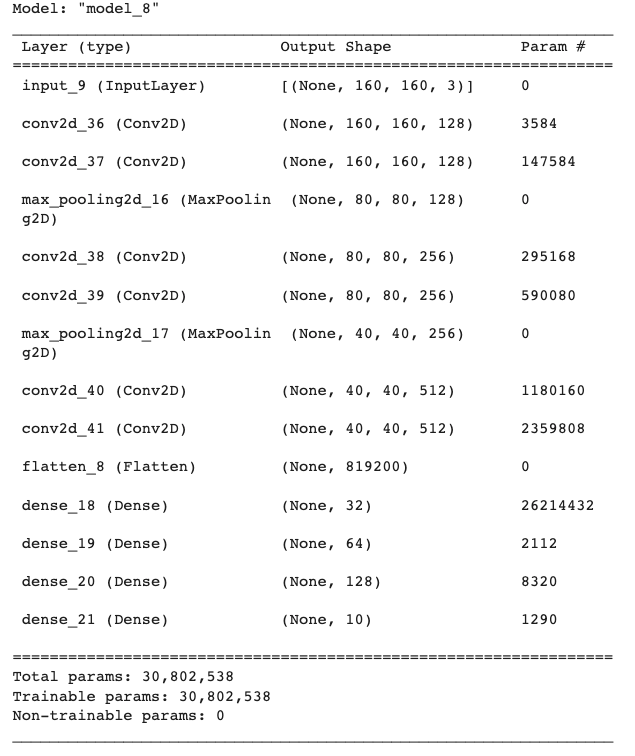

In [ ]:
# TO DO
...